In [14]:
import pandas as pd                 # for manipulating data
import pcdl                         # physicell data loader library
# import os, sys, subprocess
import math, os, sys, re
import os.path
import glob
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import xml.etree.ElementTree as ET  # for accessing PhysiCell_settings.xml
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pcdl
import seaborn as sns

In [15]:
input_dir = "../output"
mcds_ts = pcdl.TimeSeries(input_dir, microenv=True, settingxml="PhysiCell_settings.xml", graph=False, verbose=False)

Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']


KeyboardInterrupt: 

In [ ]:
# load PhysiCell_settings xml file - ONLY needed for video creation
xml_path = path + "PhysiCell_settings.xml"
xml = open(xml_path)
tree = ET.parse(xml)
xml_root = tree.getroot()

NameError: name 'path' is not defined

In [21]:
# print(mcds_ts.get_mcds_list()[0]) # you get a "pyMCDS" object. Then from there, you can do pyMCDS.get_cell_df() to get a pandas dataframe of the cells (for exmaple)

mcds_ts.get_mcds_list()[0].get_cell_df().head() # brilliant
mcds = mcds_ts.get_mcds_list()[-1]
conc_df = mcds.get_conc_df() # also brilliant - first substrate willl always be ... 7th column (0-indexed)
intervention_name = 'GAP' + r'$\rightarrow$' + 'RAS = 1'
# intervention_name = 'GAP poop'


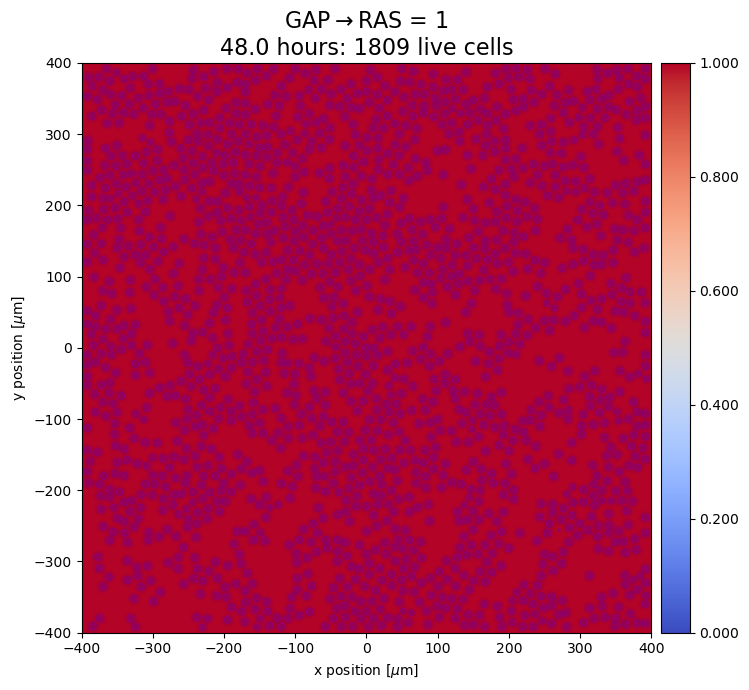

In [23]:
fig, ax = plt.subplots(figsize = (10, 7))

cell_df = mcds.get_cell_df()

number_of_live_cells = len(cell_df[cell_df['dead'] == False])
time = mcds.get_time()
time = time/60 # (convert to hours)

# iN theory these oculd be set once - don't worr yabout it. 

plot_extend = mcds.get_mesh_mnp_range() # returns in a list of tuples the lowest and highest x-axis, y-axis, and z-axis mesh center value.

# This assumes dx = dy = 20

# substrate
conc_df = mcds.get_conc_df() # also brilliant - first substrate willl always be ... 7th column (0-indexed)
substrate = conc_df.columns[6] # gives me the substrate name

xx, yy = mcds.get_mesh_2D()
substrate_conc_grid = mcds.get_concentration(substrate, 0.0)
# create_contour_plot(fig, ax, xx, yy, substrate_conc_grid, contour_options=contour_options, options=None)

# no smoothing
# ax.imshow(substrate_conc_grid, cmap='Reds', origin='lower', extent=[xx.min()-10, xx.max()-10, yy.min()-10, yy.max()+10])
substrate_im = ax.imshow(substrate_conc_grid, cmap='coolwarm', interpolation='bicubic', origin='lower', vmin=0, vmax=1, 
          extent=[xx.min()-10, xx.max()+10, yy.min()-10, yy.max()+10])

# Cells
for cell in cell_df.itertuples(): # iterrows iterate over the rows of the dataframe: returns a tuple of (index, pandas.core.series.Series). For the cells this is 119 members long \\
                                # if we don't want to iterate over the index, we can use cell_df.itertuples() instead
    # print(cell[1]['position_x'])
    # print(type(cell.position_x))
    circ_nucleus = Circle((cell.position_x, cell.position_y), radius=cell.nuclear_radius, color='purple', alpha=0.5)
    circ_cytoplasm = Circle((cell.position_x, cell.position_y), radius=cell.radius, color='purple', alpha=0.1, edgecolor=None)
    ax.add_artist(circ_cytoplasm)
    ax.add_artist(circ_nucleus)
    # ax.scatter(cell.position_x, cell.position_y, s=cell.radius, color='blue', alpha=0.7)
    ax.set_aspect('equal')


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cb = fig.colorbar(substrate_im, cax=cax, format='%.3f')
# # other fancy things you can do with colorbars - https://stackoverflow.com/questions/16595138/standalone-colorbar-matplotlib
# if options is None:
#     cb = fig.colorbar(substrate_im, cax=cax, format='%.3f')
# elif options['produce_for_panel'] is False:
#     cb = fig.colorbar(substrate_im, cax=cax, format='%.3f')
# else:
#     tick_spacing = np.linspace(contour_options['lowest_contour'], contour_options['upper_contour'], 5)
#     cb = fig.colorbar(substrate_im, cax=cax, format='%.2f', ticks=tick_spacing)
#     cb.ax.tick_params(labelsize=20)



ax.set_xlabel('x position [$\mu$m]')
ax.set_ylabel('y position [$\mu$m]')
ax.set_title(intervention_name + '\n' +str(time) + ' hours: ' + str(number_of_live_cells) + ' live cells', fontsize=16)

neg_plot_x_extend = plot_extend[0][0] - 10
pos_plot_x_extend = plot_extend[0][1] + 10
neg_plot_y_extend = plot_extend[1][0] - 10
pos_plot_y_extend = plot_extend[1][1] + 10
ax.set_xlim(neg_plot_x_extend, pos_plot_x_extend)
ax.set_ylim(neg_plot_y_extend, pos_plot_y_extend)
plt.tight_layout()
    # print(cell['position_x'])
                    # circ = Circle((plot_df.loc[j, 'position_x'], plot_df.loc[j, 'position_y']),
                    #           radius=plot_df.loc[j, 'radius'], color=colors[i], alpha=0.7)
    # ax.add_artist(plt.Circle((cell.position_x, cell.position_y), radius=cell.radius, edgecolor = 'black', fill = True, color = 'blue'))
# for idx, cell in cell_df.iterrows():
#     ax.add_artist(plt.Circle((cell['position_x'], cell['position_y']), cell['radius'], edgecolor = 'black', fill = True, color = 'blue'))

I might be able to just use:
https://github.com/elmbeech/physicelldataloader/blob/master/man/docstring/pcdl_make_movie.md

usage: pcdl_make_movie [-h] [--framerate FRAMERATE] [path] [interface]

this function generates an mp4 movie file from all image files found in the
path directory in the specified interface file format.

positional arguments:
  path                  relative or absolute path to where the images are from
                        which the mp4 movie will be generated. default is . .
  interface             specify the image format from which the mp4 movie will
                        be generated. these images have to exist under the
                        given path. they can be generated with the
                        plot_scatter or plot_contour function. default is
                        jpeg.

options:
  -h, --help            show this help message and exit
  --framerate FRAMERATE
                        specifies how many images per second will be used.
                        humans are capable of processing 12 images per second
                        and seeing them individually. higher rates are seen as
                        motion. default is 12.

homepage: https://github.com/elmbeech/physicelldataloader

OR

https://github.com/elmbeech/physicelldataloader/blob/master/man/docstring/pcdl.make_movie.md

mcdsts.make_movie('path/to/plots')

        path: string
            relative or absolute path to where the images are
            from which the movie will be generated.

        interface: string; default jpeg
            this images, from which the mp4 movie will be generated
            have to exist under the given path.
            they can be generated with the plot_scatter or plot_contour
            function.

        framerate: integer; default 12
            specifies how many images per second will be used.
            humans are capable of processing 12 images per second and
            seeing them individually. higher rates are seen as motion.


In [24]:
def make_still (mcds: object, intervention_name: str, output_path: str):

    fig, ax = plt.subplots(figsize = (8, 5.5))

    cell_df = mcds.get_cell_df()

    number_of_live_cells = len(cell_df[cell_df['dead'] == False])
    time = mcds.get_time()
    time = time/60 # (convert to hours)

    # iN theory these oculd be set once - don't worr yabout it. 

    plot_extend = mcds.get_mesh_mnp_range() # returns in a list of tuples the lowest and highest x-axis, y-axis, and z-axis mesh center value.

    # This assumes dx = dy = 20

    # substrate
    conc_df = mcds.get_conc_df() # also brilliant - first substrate willl always be ... 7th column (0-indexed)
    substrate = conc_df.columns[6] # gives me the substrate name

    xx, yy = mcds.get_mesh_2D()
    substrate_conc_grid = mcds.get_concentration(substrate, 0.0)
    # create_contour_plot(fig, ax, xx, yy, substrate_conc_grid, contour_options=contour_options, options=None)

    # no smoothing
    # ax.imshow(substrate_conc_grid, cmap='Reds', origin='lower', extent=[xx.min()-10, xx.max()-10, yy.min()-10, yy.max()+10])
    substrate_im = ax.imshow(substrate_conc_grid, cmap='coolwarm', interpolation='bicubic', origin='lower', vmin=0, vmax=1, 
            extent=[xx.min()-10, xx.max()+10, yy.min()-10, yy.max()+10])

    # Cells
    for cell in cell_df.itertuples(): # iterrows iterate over the rows of the dataframe: returns a tuple of (index, pandas.core.series.Series). For the cells this is 119 members long \\
                                    # if we don't want to iterate over the index, we can use cell_df.itertuples() instead
        # print(cell[1]['position_x'])
        # print(type(cell.position_x))
        circ_nucleus = Circle((cell.position_x, cell.position_y), radius=cell.nuclear_radius, color='purple', alpha=0.5)
        circ_cytoplasm = Circle((cell.position_x, cell.position_y), radius=cell.radius, color='purple', alpha=0.1, edgecolor=None)
        ax.add_artist(circ_cytoplasm)
        ax.add_artist(circ_nucleus)
        # ax.scatter(cell.position_x, cell.position_y, s=cell.radius, color='blue', alpha=0.7)
        ax.set_aspect('equal')


    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.10)
    cb = fig.colorbar(substrate_im, cax=cax, format='%.3f')
    cb.set_label('Concentration [AU]')
    # # other fancy things you can do with colorbars - https://stackoverflow.com/questions/16595138/standalone-colorbar-matplotlib
    # if options is None:
    #     cb = fig.colorbar(substrate_im, cax=cax, format='%.3f')
    # elif options['produce_for_panel'] is False:
    #     cb = fig.colorbar(substrate_im, cax=cax, format='%.3f')
    # else:
    #     tick_spacing = np.linspace(contour_options['lowest_contour'], contour_options['upper_contour'], 5)
    #     cb = fig.colorbar(substrate_im, cax=cax, format='%.2f', ticks=tick_spacing)
    #     cb.ax.tick_params(labelsize=20)



    ax.set_xlabel('x position [$\mu$m]')
    ax.set_ylabel('y position [$\mu$m]')
    ax.set_title(intervention_name + '\n' + str(time) + ' hours: ' + str(number_of_live_cells) + ' live cells', fontsize=20)

    neg_plot_x_extend = plot_extend[0][0] - 10
    pos_plot_x_extend = plot_extend[0][1] + 10
    neg_plot_y_extend = plot_extend[1][0] - 10
    pos_plot_y_extend = plot_extend[1][1] + 10
    ax.set_xlim(neg_plot_x_extend, pos_plot_x_extend)
    ax.set_ylim(neg_plot_y_extend, pos_plot_y_extend)
    plt.tight_layout()

    name = int(mcds.get_time())
    name = f"{name:0>8}"
    name = "still_" + str(name)
    name = os.path.join(output_path, name)
    plt.savefig(name + '.png', dpi=300)
    plt.close()

In [25]:
################## Pathing Variables ########################

# relative path to input directory
# EDIT TO BE LOCATION OF ORIGINAL MODEL FILES
rel_input_dir = 'leukemia_output/'

# relative path to output directory
# EDIT TO BE LOCATION OF WHERE YOU WANT TO STORE THE NEW MODEL FILES
rel_output_dir = 'output'

########################### PATHING ###########################
# move to PhysiCell root directory - this assumes this script is one folder below the root
os.chdir("../")
full_path = os.getcwd()
print(full_path)

# INPUTS
input_dir = os.path.join(full_path, rel_input_dir)
print("Input directory: ")
print(input_dir)

# OUTPUTS
output_dir = os.path.join(full_path, rel_output_dir)
print("Output directory: ")
print(output_dir)


# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts
Input directory: 
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/leukemia_output/
Output directory: 
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output


In [26]:
intervention_name = 'GAP' + r'$\rightarrow$' + 'RAS = 1'

for mcds in mcds_ts.get_mcds_list():
    make_still(mcds, intervention_name, output_dir)

/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000000
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000024
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000048
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000072
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000096
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000120
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000144
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000168
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000192
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000216
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000240
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000264
/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/still_00000288
/Users/JohnMetzcar/Docume

In [27]:
mcds_ts.make_movie(output_dir, interface='png')

ffmpeg version N-89110-g936a4c0-tessus Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 8.0.0 (clang-800.0.42.1)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libass --enable-libbluray --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopus --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static --disable-ffplay
  libavutil      56.  0.100 / 56.  0.100
  libavcodec     58.  3.103 / 58.  3.103
  libavformat    58.  2.100 / 58.  2.100
  libavdevice    58.  0.100 / 58.  0.100
  libavfilter     7.  1.100 /  7.  1.100
  

'/Users/JohnMetzcar/Documents/GitHub/PhysiLab/scripts/output/output_png12.mp4'

In [ ]:
# for each intervention
for i, intervention in enumerate(interventions):
    # create filepath
    path = input_dir + intervention

    # create a timeseries object
    mcds_ts = pcdl.TimeSeries(path)

    # create dictionary for this intervention
    # keys = time t; values = # live cells at time t
    data = {'intervention': interventions[i]}
    for mcds in mcds_ts.get_mcds_list():
        df_cell = mcds.get_cell_df()
        live_cells =len(df_cell[(df_cell['dead'] == False)])
        data[mcds.get_time()] = live_cells
    
    if (i == 0): df = pd.DataFrame([data])  # create the dataframe
    else: df.loc[len(df)] = data            # append the dictionary to the dataframe

# for root, dirs, files in interventions:
#     for name in files:
#         print(name)
#     for name in dirs:
#         print(name)

reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['drug_threshold', 'intervention_induced_apoptosis', 'proliferation_multiplier']
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/output00000000.xml
working on metadata ...
working on mesh data ...
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/initial_mesh0.mat
working on microenvironment data ...
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/output00000000_microenvironment0.mat
parsing: anti_IL2RB_MCL1 data
working on discrete cell data ...
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_MCL1_0_11/output00000000_cells.mat
working on graph data ...
reading: /Users/JohnMetzcar/Documents/GitHub/PhysiLab/leukemia_output/EG_IL2RB_